<div class="alert alert-warning" role="alert">
    <h4 class="alert-heading">Reminder!</h4>
    <p>Our team uses Plotly to visualise reward in a continuous manner, therefore:</p>
    <ul>
      <li>If you have Plotly and ipywidgets installed in your environment, skip the following code cell</li>
      <li>Otherwise, run the following code cell and <strong>restart your jupyter notebook!</strong></li>
    <ul>
</div>

In [1]:
!pip install plotly
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 29.9 MB/s eta 0:00:0000:0100:01


In [2]:
import numpy as np
import random
import torch

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

In [3]:
# import gym
import numpy as np
import random
import copy
from collections import namedtuple, deque

np.random.seed(42)

import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)


class TictactoeEnv:
    """
    Description:
        Classical Tic-tac-toe game for two players who take turns marking the spaces in a three-by-three grid with X or O.
        The player who succeeds in placing three of their marks in a horizontal, vertical, or diagonal row is the winner.

        The game is played by two players: player 'X' and player 'O'. Player 'x' moves first.

        The grid is represented by a 3x3 numpy array, with value in {0, 1, -1}, with corresponding values:
            0 - place unmarked
            1 - place marked with X
            -1 - place marked with O

        The game environment will recieve movement from two players in turn and update the grid.

    self.step:
        recieve the movement of the player, update the grid

    The action space is [0-8], representing the 9 positions on the grid.

    The reward is 1 if you win the game, -1 if you lose, and 0 besides.
    """

    def __init__(self):
        self.grid = np.zeros((3, 3))
        self.end = False
        self.winner = None
        self.player2value = {'X': 1, 'O': -1}
        self.num_step = 0
        self.current_player = 'X'  # By default, player 'X' goes first

    def check_valid(self, position):
        """Check whether the current action is valid or not"""
        if self.end:
            raise ValueError('This game has ended, please reset it!')
        if type(position) is int:
            position = (int(position / 3), position % 3)
        elif type(position) is not tuple:
            position = tuple(position)

        return False if self.grid[position] != 0 else True

    def step(self, position, print_grid=False):
        """ Receive the movement from two players in turn and update the grid"""
        # check the position and value are valid or not
        # position should be a tuple like (0, 1) or int [0-8]

        if self.end:
            raise ValueError('This game has ended, please reset it!')
        if type(position) is int:
            position = (int(position / 3), position % 3)
        elif type(position) is not tuple:
            position = tuple(position)
        if self.grid[position] != 0:
            raise ValueError('There is already a chess on position {}.'.format(position))

        # place a chess on the position
        self.grid[position] = self.player2value[self.current_player]

        # update
        self.num_step += 1

        ############### MODIFIED SWITCH ORDER ###########################
        self.current_player = 'X' if self.current_player == 'O' else 'O'
        # self.current_player = 'X' if self.num_step % 2 == 0 else  'O'

        # check whether the game ends or not
        self.checkEnd()

        if print_grid:
            self.render()

        return self.grid.copy(), self.end, self.winner

    def get_current_player(self):
        return self.current_player

    def checkEnd(self):
        # check rows and cols
        if np.any(np.sum(self.grid, axis=0) == 3) or np.any(np.sum(self.grid, axis=1) == 3):
            self.end = True
            self.winner = 'X'
        elif np.any(np.sum(self.grid, axis=0) == -3) or np.any(np.sum(self.grid, axis=1) == -3):
            self.end = True
            self.winner = 'O'
        # check diagnols
        elif self.grid[[0, 1, 2], [0, 1, 2]].sum() == 3 or self.grid[[0, 1, 2], [2, 1, 0]].sum() == 3:
            self.end = True
            self.winner = 'X'
        elif self.grid[[0, 1, 2], [0, 1, 2]].sum() == -3 or self.grid[[0, 1, 2], [2, 1, 0]].sum() == -3:
            self.end = True
            self.winner = 'O'
        # check if all the positions are filled
        elif (self.grid == 0).sum() == 0:
            self.end = True
            self.winner = None  # no one wins
        else:
            self.end = False
            self.winner = None

    def reset(self):
        # reset the grid
        self.grid = np.zeros((3, 3))
        self.end = False
        self.winner = None
        self.num_step = 0
        self.current_player = 'X'

        return self.grid.copy(), self.end, self.winner

    def observe(self):
        return self.grid.copy(), self.end, self.winner

    def reward(self, player='X'):
        if self.end:
            if self.winner is None:
                return 0
            else:
                return 1 if player == self.winner else -1
        else:
            return 0

    def render(self):
        # print current grid
        value2player = {0: '-', 1: 'X', -1: 'O'}
        for i in range(3):
            print('|', end='')
            for j in range(3):
                print(value2player[int(self.grid[i, j])], end=' ' if j < 2 else '')
            print('|')
        print()


class OptimalPlayer:
    '''
    Description:
        A class to implement an epsilon-greedy optimal player in Tic-tac-toe.

    About optimial policy:
        There exists an optimial policy for game Tic-tac-toe. A player ('X' or 'O') can win or at least draw with optimial strategy.
        See the wikipedia page for details https://en.wikipedia.org/wiki/Tic-tac-toe
        In short, an optimal player choose the first available move from the following list:
            [Win, BlockWin, Fork, BlockFork, Center, Corner, Side]

    Parameters:
        epsilon: float, in [0, 1]. This is a value between 0-1 that indicates the
            probability of making a random action instead of the optimal action
            at any given time.

    '''

    def __init__(self, epsilon=0.2, player='X'):
        self.epsilon = epsilon
        self.player = player  # 'x' or 'O'

    def set_player(self, player='X', j=-1):
        self.player = player
        if j != -1:
            self.player = 'X' if j % 2 == 0 else 'O'

    def empty(self, grid):
        '''return all empty positions'''
        avail = []
        for i in range(9):
            pos = (int(i / 3), i % 3)
            if grid[pos] == 0:
                avail.append(pos)
        return avail

    def center(self, grid):
        '''
        Pick the center if its available,
        if it's the first step of the game, center or corner are all optimial.
        '''
        if np.abs(grid).sum() == 0:
            # first step of the game
            return [(1, 1)] + self.corner(grid)

        return [(1, 1)] if grid[1, 1] == 0 else []

    def corner(self, grid):
        ''' Pick empty corners to move '''
        corner = [(0, 0), (0, 2), (2, 0), (2, 2)]
        cn = []
        # First, pick opposite corner of opponent if it's available
        for i in range(4):
            if grid[corner[i]] == 0 and grid[corner[3 - i]] != 0:
                cn.append(corner[i])
        if cn != []:
            return cn
        else:
            for idx in corner:
                if grid[idx] == 0:
                    cn.append(idx)
            return cn

    def side(self, grid):
        ''' Pick empty sides to move'''
        rt = []
        for idx in [(0, 1), (1, 0), (1, 2), (2, 1)]:
            if grid[idx] == 0:
                rt.append(idx)
        return rt

    def win(self, grid, val=None):
        ''' Pick all positions that player will win after taking it'''
        if val is None:
            val = 1 if self.player == 'X' else -1

        towin = []
        # check all positions
        for pos in self.empty(grid):
            grid_ = np.copy(grid)
            grid_[pos] = val
            if self.checkWin(grid_, val):
                towin.append(pos)

        return towin

    def blockWin(self, grid):
        ''' Find the win positions of opponent and block it'''
        oppon_val = -1 if self.player == 'X' else 1
        return self.win(grid, oppon_val)

    def fork(self, grid, val=None):
        ''' Find a fork opportunity that the player will have two positions to win'''
        if val is None:
            val = 1 if self.player == 'X' else -1

        tofork = []
        # check all positions
        for pos in self.empty(grid):
            grid_ = np.copy(grid)
            grid_[pos] = val
            if self.checkFork(grid_, val):
                tofork.append(pos)

        return tofork

    def blockFork(self, grid):
        ''' Block the opponent's fork.
            If there is only one possible fork from opponent, block it.
            Otherwise, player should force opponent to block win by making two in a row or column
            Amomg all possible force win positions, choose positions in opponent's fork in prior
        '''
        oppon_val = -1 if self.player == 'X' else 1
        oppon_fork = self.fork(grid, oppon_val)
        if len(oppon_fork) <= 1:
            return oppon_fork

        # force the opponent to block win
        force_blockwin = []
        val = 1 if self.player == 'X' else -1
        for pos in self.empty(grid):
            grid_ = np.copy(grid)
            grid_[pos] = val
            if np.any(np.sum(grid_, axis=0) == val * 2) or np.any(np.sum(grid_, axis=1) == val * 2):
                force_blockwin.append(pos)
        force_blockwin_prior = []
        for pos in force_blockwin:
            if pos in oppon_fork:
                force_blockwin_prior.append(pos)

        return force_blockwin_prior if force_blockwin_prior != [] else force_blockwin

    def checkWin(self, grid, val=None):
        # check whether the player corresponding to the val will win
        if val is None:
            val = 1 if self.player == 'X' else -1
        target = 3 * val
        # check rows and cols
        if np.any(np.sum(grid, axis=0) == target) or np.any(np.sum(grid, axis=1) == target):
            return True
        # check diagnols
        elif grid[[0, 1, 2], [0, 1, 2]].sum() == target or grid[[0, 1, 2], [2, 1, 0]].sum() == target:
            return True
        else:
            return False

    def checkFork(self, grid, val=None):
        # check whether the player corresponding to the val will fork
        if val is None:
            val = 1 if self.player == 'X' else -1
        target = 2 * val
        # check rows and cols
        rows = (np.sum(grid, axis=0) == target).sum()
        cols = (np.sum(grid, axis=1) == target).sum()
        diags = (grid[[0, 1, 2], [0, 1, 2]].sum() == target) + (grid[[0, 1, 2], [2, 1, 0]].sum() == target)
        if (rows + cols + diags) >= 2:
            return True
        else:
            return False

    def randomMove(self, grid):
        """ Chose a random move from the available options. """
        avail = self.empty(grid)

        return avail[random.randint(0, len(avail) - 1)]

    def act(self, grid, **kwargs):
        """
        Goes through a hierarchy of moves, making the best move that
        is currently available each time (with probabitity 1-self.epsilon).
        A touple is returned that represents (row, col).
        """
        # whether move in random or not
        if random.random() < self.epsilon:
            return self.randomMove(grid)

        ### optimial policies

        # Win
        win = self.win(grid)
        if win != []:
            return win[random.randint(0, len(win) - 1)]
        # Block win
        block_win = self.blockWin(grid)
        if block_win != []:
            return block_win[random.randint(0, len(block_win) - 1)]
        # Fork
        fork = self.fork(grid)
        if fork != []:
            return fork[random.randint(0, len(fork) - 1)]
        # Block fork
        block_fork = self.blockFork(grid)
        if block_fork != []:
            return block_fork[random.randint(0, len(block_fork) - 1)]
        # Center
        center = self.center(grid)
        if center != []:
            return center[random.randint(0, len(center) - 1)]
        # Corner
        corner = self.corner(grid)
        if corner != []:
            return corner[random.randint(0, len(corner) - 1)]
        # Side
        side = self.side(grid)
        if side != []:
            return side[random.randint(0, len(side) - 1)]

        # random move
        return self.randomMove(grid)


def grid_to_state(grid):
    """Convert ndarray to flattened python list"""
    return grid.flatten().tolist()


def state_to_grid(state):
    """Restore flattened python list back to 3*3 grid"""
    return np.asarray(state).reshape((3, 3))


class QAgent(OptimalPlayer):
    def __init__(self, epsilon=0.2, player='X'):
        super(QAgent, self).__init__(epsilon, player)
        self.player = player
        self.curr_state = None

    def act(self, grid, learner_lib):

        # In act, states and q_table are used but not updated.
        state_table = learner_lib.states
        q_table = learner_lib.q_table

        # Convert 3*3 ndarray to list for reference
        self.curr_state = grid_to_state(grid)

        # Retrieve q-values of the current state
        # state_idx = state_table.index(self.curr_state)

        # print(f'state_idx {state_idx}')
        # action_qvalues = q_table[state_idx]
        # print(f'action values {action_qvalues}')

        # Exploitation
        avail_actions = self.avail_action_from_state(self.curr_state, state_table, q_table)
        best_action = avail_actions[0]

        # Exploration
        if random.random() < self.epsilon:
            best_action = random.choice(avail_actions)
            # print(f"Exploration random {best_action}")

        return int(best_action)

    def avail_action_from_state(self, state, state_table, q_table):
        """
        Return available action indexes according to their qvalue in descending order.
        """
        avail = []

        state_idx = state_table.index(state)
        action_qvalues = q_table[state_idx]

        # Retrieve a list of action index with action q-value in descending order
        # Here action idx is actually position on game board
        sorted_action_idx = np.flip(np.argsort(action_qvalues))

        # Retrieve the available action indexes
        # Action is not available if position is already taken
        for idx in sorted_action_idx:
            if state[idx] == 0:
                avail.append(idx)

        return avail

    def update_states(self, state, learner_lib):

        if state not in learner_lib.states:
            learner_lib.add_state(state)
            learner_lib.add_q()

    def update_q(self, state, action, next_state, reward, learner_lib):

        curr_state_idx = learner_lib.states.index(state)

        if next_state is not None:
            next_state_idx = learner_lib.states.index(next_state)

            next_action = \
                self.avail_action_from_state(next_state, learner_lib.states, learner_lib.q_table)[0]
            greedy_qsa = learner_lib.q_table[next_state_idx][next_action]

            learner_lib.update_q(curr_state_idx, action, reward, greedy_qsa=greedy_qsa)
        else:
            learner_lib.update_q(curr_state_idx, action, reward, greedy_qsa=0)


class QLibrary:
    """
    This class is used to store the changing states and Q values. 
    """

    def __init__(self, alpha=0.05, gamma=0.99) -> None:
        self._alpha = alpha
        self._gamma = gamma

        self.states = [[0] * 9]
        self.q_table = [[0] * 9]  # 9 actions, each position is an action

    def add_state(self, new_state):
        """
        Setter Equivalent
        """
        self.states.append(new_state)

    def add_q(self):
        """
        Setter Equivalent
        """
        self.q_table.append([0] * 9)

    def update_q(self, state_idx, action_idx, reward, greedy_qsa):
        """
        This function is used to update Q values according to reward and Q values of next step.

        params:
            state_idx: index of state. Used to retrive the specified Q values.
            action_idx: index of action. Used to retrive the specified Q values.
            greedy_qsa: maximal Q values of next step. 0 at terminal states.
            reward: reward after current action step.
        """
        qsa = self.q_table[state_idx][action_idx]
        # print(qsa)

        self.q_table[state_idx][action_idx] = qsa + self._alpha * (reward + self._gamma * greedy_qsa - qsa)
        # print(self.q_table[state_idx][action_idx])        


class FCN(nn.Module):
    """
    This class is to build the neural network for inferencing the next step.
    """

    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(18, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 9)
        self.relu = torch.nn.ReLU()  # instead of Heaviside step fn

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        output = self.fc3(x)
        return output


class DeepQAgent:
    """
    This class is used to instantiate an agent for DQN.
    """

    def __init__(self, epsilon, player='X') -> None:
        # setup.
        self.epsilon = epsilon
        self.player = player

        # The first model makes the predictions for Q-values which make a action.
        self.model = FCN()
        # Build a target model for the prediction of future rewards.
        # The weights of a target model is fixed when the first model update weights.  
        # Thus when the loss between the Q-values is calculated the target Q-value is stable.
        self.target_model = FCN()
        self.target_model.load_state_dict(self.model.state_dict())

        # optimizer.
        self._lr = 5e-4
        self.optimizer = torch.optim.Adam(
            self.model.parameters(),
            lr=self._lr,
            # betas=(meta_conf.beta if hasattr(meta_conf, "beta") else 0.9, 0.999),
            # weight_decay=weight_decay,
        )

        # define criterion function.
        # self.criterion = torch.nn.HuberLoss(reduction='mean', delta=1.0)
        self.criterion = torch.nn.HuberLoss(delta=1.0)
        # self.criterion = torch.nn.SmoothL1Loss()

        # fixed parameters.
        self._gamma = 0.99
        self._batch_size = 64
        self._num_actions = 9

    def act(self, grid):

        """This function is used to guide the move of agents."""
        if random.random() < self.epsilon:
            # take random actions.
            action = torch.randint(self._num_actions, (1,))
        else:
            with torch.no_grad():
                action_probs = self.model(grid.unsqueeze(0))
                _, action = torch.max(action_probs, 1)
        return action

    def train(self, replay_buffer, update_target=False):
        """This function is used to update the network parameters."""
        # retrive batches.
        # batch = replay_buffer.get_batch(self._batch_size)
        if len(replay_buffer) < replay_buffer.batch_size:
            return
        transitions = replay_buffer.sample(replay_buffer.batch_size)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                                batch.next_state)), dtype=torch.bool)
        if replay_buffer.batch_size > 1:
            non_final_next_states = torch.cat([s.unsqueeze(0) for s in batch.next_state
                                        if s is not None], 0)
        else:
            if batch.next_state[0] is None:
                non_final_next_states = None
            else:
                non_final_next_states = torch.cat([batch.next_state[0].unsqueeze(0)], 0)

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        # states = torch.cat([batch[i]['state'].unsqueeze(0) for i in range(len(batch))], 0)
        # next_states = torch.cat([batch[i]['next_state'].unsqueeze(0) for i in range(len(batch))], 0)
        # rewards = torch.FloatTensor([batch[i]['reward'] for i in range(len(batch))])
        # actions = torch.LongTensor([batch[i]['action'] for i in range(len(batch))])
        # dones = torch.FloatTensor([batch[i]['done'] for i in range(len(batch))])
        # masks = F.one_hot(actions, self._num_actions)
        state_action_values = self.model(state_batch).gather(1, action_batch.unsqueeze(1))
        # calculate target values.
        # with torch.no_grad():
        #     future_rewards = self.target_model(next_states)
        next_state_values = torch.zeros(replay_buffer.batch_size)
        if non_final_next_states is not None:
            next_state_values[non_final_mask] = self.target_model(non_final_next_states).max(1)[0].detach()
        else:
            pass
        # target_q_values = (1. - dones) * (rewards + self._gamma * torch.max(future_rewards, dim=1)[0]) - dones
        # target_q_values = rewards + (1 - dones) * self._gamma * torch.max(future_rewards, dim=1)[0]
        expected_state_action_values = (next_state_values * self._gamma) + reward_batch

        # update action model prameters.
        # q_values = self.model(states)
        # qsa = torch.sum(torch.mul(q_values, masks), dim=1)
        # qsa = self.model(states).gather(1, actions)

        # calculate loss.
        loss = self.criterion(state_action_values, expected_state_action_values.unsqueeze(1))


        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if update_target:
            self.target_model.load_state_dict(self.model.state_dict())

        return loss


Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class Buffer:
    """This class is used to instantiate replay buffers."""

    def __init__(self, capacity, batch_size):
        self.memory = deque([], maxlen=capacity)
        self.batch_size = batch_size

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Helper functions

In [4]:
colours = px.colors.qualitative.Plotly

In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
def render_figure_widge(mode=None):
    gofig = go.FigureWidget()
    gofig.update_xaxes(title_text='Epoch', autorange=True)
    gofig.update_yaxes(title_text='Avg. Reward', autorange=True)
    
    if mode == 'validation':
        gofig.update_yaxes(title_text='Diff. Rate', autorange=True)
        
    gofig.update_layout(width=1200, height=800, hovermode="x unified")
    
    # Only for question 11 and 12
    if mode == 'Reward+Loss':
        gofig = make_subplots(rows=1, cols=2, subplot_titles=['Average Reward', 'Training Loss'])
        gofig.update_layout(width=1400, height=500, hovermode="x unified")
        gofig = go.FigureWidget(gofig)
        
    return gofig

In [7]:
def init_figure_widge(fig_widge, mode, colour, epsilon_opt=None, epsilon_learn=None, n_star=None):
    # Mode epsilon only used for question 11
    if mode == 'epsilon':
        if not (epsilon_learn >= 0 and epsilon_learn < 1):
            raise Exception('Epsilon value empty or out of range')
        
        # For average reward - 0
        fig_widge.add_trace(go.Scatter(x=[0], y=[0], name=f'Avg. Reward = {epsilon_learn}', marker=dict(color=colour)), row=1, col=1)
        
        # For training loss - 1
        fig_widge.add_trace(go.Scatter(x=[0], y=[0], name=f'Tr. Loss = {epsilon_learn}', marker=dict(color=colour)), row=1, col=2)
        
    # Mode 'descrease exploration' only used for question 12
    elif mode == 'decrease exploration':
        if not isinstance(n_star,int):
            raise TypeError('Cannot find or recognise n_star')       
        
        # For average reward - 0
        fig_widge.add_trace(go.Scatter(x=[0], y=[0], name=f'Avg. Reward = {n_star}', marker=dict(color=colour)), row=1, col=1)
        
        # For training loss - 1
        fig_widge.add_trace(go.Scatter(x=[0], y=[0], name=f'Tr. Loss = {n_star}', marker=dict(color=colour)), row=1, col=2)
        
    elif mode == 'validate n*':
        fig_widge.add_scatter(x=[0], y=[0], name=f'M_opt n* = {n_star}', marker=dict(color=colour))
        fig_widge.add_scatter(x=[0], y=[0], name=f'M_rand n* = {n_star}', marker=dict(color=colour), line=dict(dash='dot'))
        
    elif mode == 'validate epsilon opt':
        fig_widge.add_scatter(x=[0], y=[0], name=f'M_opt epilson opt= {epsilon_opt}', marker=dict(color=colour))
        fig_widge.add_scatter(x=[0], y=[0], name=f'M_rand epilson opt= {epsilon_opt}', marker=dict(color=colour), line=dict(dash='dot'))
        
    else:
        raise NotImplementedError("Unable to recognise mode")
            
    return fig_widge

In [8]:
def check_available(grid, pos):
    """Input grid should be 2 * 3 * 3 tensor"""
    x, y = pos // 3, pos % 3
    if grid[0,x,y] == grid[1,x,y] == 0:
        return True
    return False

In [9]:
def grid2state(grid, learner_value):
    grid2d = np.tile(grid, (2,1)).reshape(2,3,3)
    if learner_value == "X":
        grid2d[0] = np.clip(grid2d[0], 0, 1)
        grid2d[1] = np.clip(-grid2d[1], 0, 1)
    else:
        grid2d[0] = np.clip(-grid2d[0], 0, 1)
        grid2d[1] = np.clip(grid2d[1], 0, 1)
    return torch.Tensor(grid2d).to(DEVICE)

In [10]:
def validation(epsilon_opt, epsilon_learn, DeepQLearner, epoch=500):
    env = TictactoeEnv()
    Turns = np.array(['O','X'])
    reward_sum = 0
    
    for i in range(epoch):
        np.random.seed(i)
        
        # Our policy makes the first move in the first 250 games
        if i < 250:
            Turns = np.array(['O','X'])
        else:
            Turns = np.array(['X','O'])
        
        env.reset()
        grid, _, __ = env.observe()
        player_opt = OptimalPlayer(epsilon=epsilon_opt, player=Turns[0])
        player_learn = DeepQLearner
        player_learn.epsilon = epsilon_learn
        player_learn.player = Turns[1]

        for j in range(9):
            if env.current_player == player_opt.player:
                action = player_opt.act(grid)
                grid, end, winner = env.step(action, print_grid=False)
            else:
                state = grid2state(grid, player_learn.player).to(DEVICE)
                action = player_learn.act(state)
                # new_position = player_learn.act(grid, q_library)
                if check_available(grid2state(grid, player_learn.player), action.item()):
                    grid, end, winner = env.step(action.item(), print_grid=False)
                else:
                    # End the game if the agent takes an unavailable action
                    end = True
                    # Give the agent a negative reward
                    reward = -1
                    
                    # # Opt wins the games
                    env.winner = player_opt.player

            if end:
                reward_sum += env.reward(player=player_learn.player)
                env.reset()
                break
                
    return reward_sum/epoch

In [11]:
def run_simulation(epsilon_opt, buffer_capacity=10000, batch_size=64, epoch=20000, plot_interval=250, 
                   colour='black', epsilon_learn_init=None, n_star=None, fig_widge=None, mode=None):

    any_epsilon = (epsilon_learn_init is None) and (n_star is None)
    assert not any_epsilon, "Both epsilon_learn and n_star is None! At least having one of them."

    env = TictactoeEnv()        
    Turns = np.array(['X','O'])
    plot_interval = 250

    # rendering in figure widge
    if fig_widge is not None:
        init_figure_widge(fig_widge, mode, colour, 
                          epsilon_opt=epsilon_opt, 
                          epsilon_learn=epsilon_learn_init, 
                          n_star=n_star)
        
    replay_memory = Buffer(capacity=buffer_capacity, batch_size=batch_size)
    player_opt = OptimalPlayer(epsilon=epsilon_opt, player=Turns[0])
    player_learn = DeepQAgent(epsilon=epsilon_learn_init, player=Turns[1])

    epsilon_min = 0.1
    epsilon_max = 0.8

    reward_sum = 0
    loss_sum = 0
    loss_step = 0
    average_rewards = []
    average_losses = []

    for i in range(epoch):
        # if mode == 'decrease exploration' or 'validation':
        if epsilon_learn_init is None:
            assert n_star is not None, "In this setting, we use n_star to tune the epsilon_learn."
            epsilon_learn = max(epsilon_min, epsilon_max*(1-(i+1)/n_star))
        else:
            epsilon_learn = epsilon_learn_init
        
        player_learn.epsilon = epsilon_learn

        env.reset()
        grid, _, _ = env.observe()

        # Switch Order
        Turns = Turns[::-1]
        player_opt.player = Turns[0]
        player_learn.player = Turns[1]
        env.current_player  = 'X'

        state = None
        next_state = None

        for j in range(9):
            if env.current_player == player_opt.player:
                action_opt = player_opt.act(grid)
                grid, end, winner = env.step(action_opt, print_grid=False)
                
                # Get reward
                reward = env.reward(player=player_learn.player)
                
                # In case opt plays first
                if j > 0:
                    next_state = grid2state(grid, player_learn.player)
            else:
                state = grid2state(grid, player_learn.player)
                action = player_learn.act(state)
                action = action.to(DEVICE)

                # Check the availability of current action.
                if check_available(grid2state(grid, player_learn.player), action.item()):
                    grid, end, winner = env.step(action.item(), print_grid=False)

                    # Get reward.
                    reward = env.reward(player=player_learn.player)
                else:
                    # End the game if the agent takes an unavailable action
                    end = True
                    unavailable_action = True
                    # Give the agent a negative reward
                    reward = -1
                    
                    # Opponent wins the games
                    env.winner = player_opt.player

                    
            if not end:
                # In case opt players first - next_state does not exist
                if next_state != None:
                    replay_memory.push(state.unsqueeze(0), action, next_state, torch.tensor([reward], device=DEVICE))
                    if len(replay_memory) >= replay_memory.batch_size:
                        loss = player_learn.train(replay_memory)
                        loss_step += 1
                        loss_sum += loss
                    next_state = None
                    
            if end:
                # Once the game ends, no matter which player plays first
                # Update is the same.
                if env.winner == player_opt.player:
                    # If opt wins the game, reward is guaranteed to be update-to-date
                    reward = -1
                elif env.winner == player_learn.player:
                    # our agent wins.
                    reward = 1
                else:
                    # Draw
                    reward = 0

                next_state = None
                # Update target model every 500 epoch
                update_target = False

                if (i+1) % 500 == 0:
                    update_target = True
                replay_memory.push(state.unsqueeze(0), action, next_state, torch.tensor([reward], device=DEVICE))
                if len(replay_memory) >= replay_memory.batch_size:
                    loss = player_learn.train(replay_memory, update_target)
                    loss_step += 1
                    loss_sum += loss
                    
                reward_sum += reward
                env.reset()
                break       
            
        #############################
        ######### Plot ##############

        if (i+1) % plot_interval == 0:
            # calculate average reward at the end of the current interval.
            average_reward = reward_sum / plot_interval  
            average_loss = loss_sum / loss_step
            # print(average_reward)  
            # print(average_loss)
            
            if not 'validate' in mode:
                idx = len(fig_widge.data)-2
                
                fig_widge.data[idx].x = np.append(fig_widge.data[idx].x, i+1)[0:]
                fig_widge.data[idx].y = np.append(fig_widge.data[idx].y, average_reward)[0:]
                
                fig_widge.data[idx+1].x = np.append(fig_widge.data[idx+1].x, i+1)[0:]
                fig_widge.data[idx+1].y = np.append(fig_widge.data[idx+1].y, average_loss.item())[0:]
                
            else:
                M_opt = validation(0, 0, player_learn, epoch=500)
                M_rand = validation(1, 0, player_learn, epoch=500)
                
                idx = len(fig_widge.data)-2
                fig_widge.data[idx].x = np.append(fig_widge.data[idx].x, i+1)[0:]
                fig_widge.data[idx].y = np.append(fig_widge.data[idx].y, M_opt)[0:]
                fig_widge.data[idx+1].x = np.append(fig_widge.data[idx+1].x, i+1)[0:]
                fig_widge.data[idx+1].y = np.append(fig_widge.data[idx+1].y, M_rand)[0:]
                fig_widge.layout.title.text = f'Epoch {i+1}, M_opt = {M_opt}, M_rand = {M_rand}'

            average_rewards.append(average_reward)
            average_losses.append(average_loss)
            # reset reward_sum.
            reward_sum = 0
            loss_sum = 0

In [12]:
def self_practice_simulation(epsilon_opt=None, epoch=20000, plot_interval=250, 
                   colour='black', epsilon_learn_init=None, n_star=None, fig_widge=None, mode=None):

    any_epsilon = (epsilon_learn_init is None) and (n_star is None)
    assert not any_epsilon, "Both epsilon_learn and n_star is None! At least having one of them."

    env = TictactoeEnv()        
    Turns = np.array(['X','O'])
    plot_interval = 250

    # rendering in figure widge
    if fig_widge is not None:
        if n_star is None:
            fig_widge.add_scatter(x=[0], y=[0], name=f'M-opt vs. Q-agent, epsilon = {epsilon_learn_init}', marker=dict(color=colour))
            fig_widge.add_scatter(x=[0], y=[0], name=f'M-rand vs. Q-agent, epsilon = {epsilon_learn_init}', marker=dict(color=colour), line=dict(dash='dot'))
        else:
            fig_widge.add_scatter(x=[0], y=[0], name=f'M-opt vs. Q-agent, n* = {n_star}', marker=dict(color=colour))
            fig_widge.add_scatter(x=[0], y=[0], name=f'M-rand vs. Q-agent, n* = {n_star}', marker=dict(color=colour), line=dict(dash='dot'))
        
    replay_memory = Buffer(capacity=10000, batch_size=64)
    shared_model = FCN()
    # Use player_A as our agent. Need to exchange order when using player_B.
    player_A = DeepQAgent(epsilon=epsilon_learn_init, player='O', model=shared_model)
    player_B = DeepQAgent(epsilon=epsilon_learn_init, player='X', model=shared_model)

    epsilon_min = 0.1
    epsilon_max = 0.8

    reward_sum_A = 0
    loss_sum_A = 0
    loss_step_A = 0
    average_rewards_A = []
    average_losses_A = []

    for i in range(epoch):
        # if mode == 'decrease exploration' or 'validation':
        if epsilon_learn_init is None:
            assert n_star is not None, "In this setting, we use n_star to tune the epsilon_learn."
            epsilon_learn = max(epsilon_min, epsilon_max*(1-(i+1)/n_star))
        else:
            epsilon_learn = epsilon_learn_init
        
        player_A.epsilon = epsilon_learn
        player_B.epsilon = epsilon_learn

        env.reset()
        grid, _, _ = env.observe()

        # Switch Order
        # Turns = Turns[::-1] 
        # env.current_player = Turns[0]
        Turns = Turns[::-1]
        player_A.player = Turns[0]
        player_B.player = Turns[1]
        env.current_player  = 'X'

        state_A = None
        next_state_A = None
        state_B = None
        next_state_B = None

        for j in range(9):
            if env.current_player == player_A.player:
                # state_A is observed from the perspective of A.
                state_A = grid2state(grid, player_A.player)
                action_A = player_A.act(state_A)
                action_A = action_A.to(DEVICE)
                
                # Get reward
                if check_available(grid2state(grid, player_A.player), action_A.item()):
                    grid, end, winner = env.step(action_A.item(), print_grid=False)

                    # Get reward.
                    reward_A = env.reward(player=player_A.player)
                    # In case A plays first.
                    if j > 0:
                        next_state_B = grid2state(grid, player_B.player)
                else:
                    # End the game if the agent takes an unavailable action
                    end = True
                    # Give the agent a negative reward
                    reward_A = -1
                    
                    # # Opt wins the games
                    env.winner = player_B.player

            else:
                # state_B is observed from the perspective of B.
                state_B = grid2state(grid, player_B.player)
                action_B = player_B.act(state_B)
                action_B = action_B.to(DEVICE)

                if check_available(grid2state(grid, player_B.player), action_B.item()):
                    grid, end, winner = env.step(action_B.item(), print_grid=False)

                    # Get reward.
                    reward_B = env.reward(player=player_B.player)
                    # In case A plays first
                    if j > 0:
                        next_state_A = grid2state(grid, player_A.player)
                else:
                    # End the game if the agent takes an unavailable action
                    end = True
                    # Give the agent a negative reward
                    reward_B = -1
                    
                    # # Opt wins the games
                    env.winner = player_A.player
    
            if not end:
                # In case opt players first - next_state does not exist
                if next_state_A != None:
                    replay_memory.push(state_A.unsqueeze(0), action_A, next_state_A, torch.tensor([reward_A], device=DEVICE))
                    if len(replay_memory) >= replay_memory.batch_size:
                        loss_A = player_A.train(replay_memory)
                        loss_sum_A += loss_A
                        loss_step_A += 1
                    next_state_A = None
                
                if next_state_B != None:
                    replay_memory.push(state_B.unsqueeze(0), action_B, next_state_B, torch.tensor([reward_B], device=DEVICE))
                    if len(replay_memory) >= replay_memory.batch_size:
                        _ = player_B.train(replay_memory)
                    next_state_B = None
                          
            if end:
                # Once ending the game, no matter which player plays first
                # Update is the same
                if env.winner == player_A.player:
                    # If opt wins the game, reward is guaranteed to be update-to-date
                    reward_A = 1
                    reward_B = -1
                elif env.winner == player_B.player:
                    reward_A = -1
                    reward_B = 1
                else:
                    # Draw
                    reward_A = 0
                    reward_B = 0
                
                # If one agent wins the game, we don't actually real next_state
                # Because q(s', a') will be cancelled out.
                next_state_A = None
                next_state_B = None
                
                replay_memory.push(state_A.unsqueeze(0), action_A, next_state_A, torch.tensor([reward_A], device=DEVICE))
                replay_memory.push(state_B.unsqueeze(0), action_B, next_state_B, torch.tensor([reward_B], device=DEVICE))
                
                # Update target model every 500 epoch.
                update_target = False

                if (i+1) % 500 == 0:
                    update_target = True

                # Training model when game over, and replay_memory size >= batch size
                if len(replay_memory) >= replay_memory.batch_size:
                    loss_A = player_A.train(replay_memory, update_target)
                    loss_sum_A += loss_A
                    loss_step_A += 1
                    _ = player_B.train(replay_memory, update_target)

                    
                # always focus on the average reward of player_A.
                reward_sum_A += reward_A
                env.reset()
                break       
            
        #############################
        ######### Plot ##############

        if (i+1) % plot_interval == 0:
            # calculate average reward at the end of the current interval.
            average_reward_A = reward_sum_A / plot_interval  
            average_loss_A = loss_sum_A / loss_step_A
            print(average_reward_A)  
            print(average_loss_A)
            
            M_opt_1 = validation(0, 0, player_A, epoch=500)
            M_rand_1 = validation(1, 0, player_A, epoch=500)

            idx = len(fig_widge.data)-2
            fig_widge.data[idx].x = np.append(fig_widge.data[idx].x, i+1)[0:]
            fig_widge.data[idx].y = np.append(fig_widge.data[idx].y, M_opt_1)[0:]
            fig_widge.data[idx+1].x = np.append(fig_widge.data[idx+1].x, i+1)[0:]
            fig_widge.data[idx+1].y = np.append(fig_widge.data[idx+1].y, M_rand_1)[0:]
            fig_widge.layout.title.text = f'Epoch {i+1}, M_opt = {M_opt_1}, M_rand = {M_rand_1}'

            average_rewards_A.append(average_reward_A)
            average_losses_A.append(average_loss_A)
            # reset reward_sum.
            reward_sum_A = 0
            loss_sum_A = 0
            loss_step_A = 0

    return (shared_model, replay_memory)

In [13]:
def generate_text(lst):
    text = ['X' if x == 1 else 'O' if x == -1 else '' for x in lst]
    return np.flip(np.reshape(text, (3, 3)), 0)

In [14]:
def retrieve_avail_qv(q_values, states):
    return [val if (states[idx] == 0) else 0 for (idx, val) in enumerate(q_values)]

Question 11.

AttributeError: type object 'DOMWidget' has no attribute '_ipython_display_'

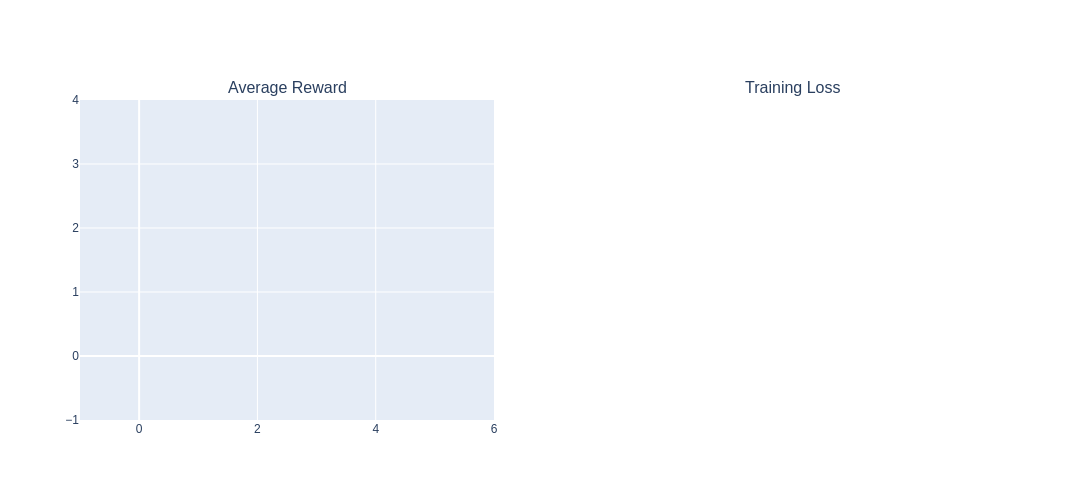

In [15]:
fw1 = render_figure_widge('Reward+Loss')
fw1

In [16]:
epsilon_opt = 0.5  # This epsilon value represents exploration level of optimal player. Fixed in Question 1.
epsilon_learn = [0.0, 0.2, 0.4, 0.8]  # This epsilon value represents exploration level of Q-learning agent. Defind by ourselves.
epoch = 20000  # number of games to play in Question 1.
plot_interval = 250  # The interval of games to calculate an average reward.
for idx, epsilon in enumerate(epsilon_learn):
    run_simulation(
        epsilon_opt=epsilon_opt,
        epsilon_learn_init=epsilon, 
        fig_widge=fw1,
        colour=colours[idx],
        mode='epsilon'
        )

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking arugment for argument mat1 in method wrapper_addmm)

Question 12.

In [ ]:
fw2 = render_figure_widge('Reward+Loss')
fw2

In [ ]:
epsilon_opt = 0.5  # This epsilon value represents exploration level of optimal player. Fixed in Question 1.
epsilon_learn = [0.0, 0.2, 0.4, 0.8]  # This epsilon value represents exploration level of Q-learning agent. Defind by ourselves.
epoch = 20000  # number of games to play in Question 1.
plot_interval = 250  # The interval of games to calculate an average reward.
for idx, epsilon in enumerate(epsilon_learn):
    run_simulation(
        epsilon_opt=epsilon_opt,
        buffer_capacity=1,
        batch_size=1,
        epsilon_learn_init=epsilon, 
        fig_widge=fw2,
        colour=colours[idx],
        mode='epsilon'
        )

Question 13.

In [ ]:
fw3 = render_figure_widge()
fw3

In [ ]:
epsilon_opt = 0.5  # This epsilon value represents exploration level of optimal player.
n_stars = [1, 100, 1000, 2000, 5000, 10000, 20000, 40000]
epoch = 20000  # number of games to play in Question 1.
plot_interval = 250  # The interval of games to calculate an average reward.
for idx, n_s in enumerate(n_stars):
    run_simulation(
        epsilon_opt=epsilon_opt, 
        n_star=n_s,
        epoch=epoch, 
        plot_interval=plot_interval, 
        colour=colours[idx%len(colours)], 
        fig_widge=fw3, 
        mode="validate n*"
        )

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

Question 14

In [ ]:
fw4 = render_figure_widge()
fw4

In [ ]:
epsilon_opts = [.0, .2, .4, .6, .8]
best_n_star = 1000
for idx, epsilon_opt in enumerate(epsilon_opts):
    run_simulation(
        epsilon_opt=epsilon_opt, 
        n_star=best_n_star,
        fig_widge=fw4,
        colour=colours[idx%len(colours)],
        mode='validate epsilon opt'
        )

Question 16

In [ ]:
fw5 = render_figure_widge('validation')
fw5

In [ ]:
epsilon_learn = [0, 0.2, 0.4, 0.6, 0.8]
for idx, epsilon in enumerate(epsilon_learn):
    self_practice_simulation(
        colour=colours[idx%len(colours)],
        epsilon_learn_init=epsilon,
        fig_widge=fw5,
        )

Question 17

In [ ]:
fw6 = render_figure_widge('validation')
fw6

In [ ]:
n_stars = [1, 100, 1000, 5000, 10000, 20000]
libraries = []

for idx, n_s in enumerate(n_stars):
    libraries.append(self_practice_simulation(colour=colours[idx%len(colours)],n_star=n_s,fig_widge=fw6))

Question 19 

In [ ]:
# Retrieve FCN model for qvalue prediction and memory for sampling
model, memory = self_practice_simulation(colour='black',n_star=1000,fig_widge=render_figure_widge('validation'))

In [ ]:
fig = make_subplots(rows=1, cols=3)

for i in range(3):
    random_sample = memory.sample(1)
    state  = random_sample[0].state
    grid = state[0][0] - state[0][1]
    lst = grid_to_state(grid.cpu().detach().numpy())

    qvalue = model(state)[0].cpu().tolist()
    
    fig.add_trace(go.Heatmap(z=np.flip(np.reshape(retrieve_avail_qv(qvalue, lst), (3,3)), 0),
                         text= generate_text(lst), texttemplate="%{text}",
                         textfont={"size":20}, coloraxis='coloraxis'), row=1, col=i+1)
    
fig.update_layout(width=1200, height=500)
fig.update_xaxes(visible=False)       
fig.update_yaxes(visible=False)
fig.update_layout(coloraxis=dict(colorscale='RdBu', colorbar_thickness=23))
fig.show()